# <center>Forecast of delinquency by the borrower</center>

### Data set description

The data is historical data for 251503 borrowers (https://www.kaggle.com/c/GiveMeSomeCredit/data ). The task is a binary classification. The goal is to predict whether this or that borrower will experience financial difficulties in the next 2 years, i.e. whether there will be a delay on the loan. The sample is divided into training and test (150000 in the training part, 101503 in the test).

This task to be solved will be valuable to both lenders and borrowers to assess the ability to repay the debt on time.

### Description of features

* 1 - __SeriousDlqin2yrs__ - will there be a delay of more than 90 days in the next 2 years (target label) (Yes/No)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - the total balance of credit cards and lines of credit, excluding real estate debt, installment debt divided by the amount of credit limits (interest)
* 3 - __age__ - Borrower's age (in years)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - the number of delays in 30-59 days (Integer)
* 5 - __DebtRatio__ - debt ratio, i.e. the amount of monthly debt payments, alimony and living expenses divided by monthly pre-tax income (interest)
* 6 - __Monthly Income__ - monthly income (float)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - number of open loans and credit lines (Integer)
* 8 - __NumberOfTimes90DaysLate__ - number of delays over 90 days (Integer)
* 9 - __NumberRealEstateLoansOrLines__ - number of mortgages and real estate loans, including home equity lines of credit (Integer)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - number of past dues of 60-89 days in the last 2 years (Integer)
* 11 - __NumberOfDependents__ - number of dependents in the family (excluding the borrowers themselves) (Integer)

##### Required imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import validation_curve, learning_curve
RANDOM_STATE = 17

# Part 1 - Dataset preparation

In [2]:
df = pd.read_csv('cs-training.csv', index_col=0)

In [3]:
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [5]:
list(set(df._get_numeric_data().columns)-set(df.columns))

[]

### I. Exploratory analysis.

##### 01. Check the values in the 'age' column

In [6]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.age.value_counts()).sort_index()

,age
0,1
21,183
22,434
23,641
24,816
25,953
26,1193
27,1338
28,1560
29,1702


##### Delete the line where the age is '0', because this case is unique.

In [7]:
pd.set_option('display.max_rows', 10)
df.loc[df.age==0].index[0] # calculate the index of the row where the age is '0'
df.drop(df.loc[df.age==0].index[0], axis=0, inplace=True)

##### 02. Check the values in the 'NumberOfTime30-59DaysPastDueNotWorse' column

In [8]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()).sort_index()

,NumberOfTime30-59DaysPastDueNotWorse
0,126018
1,16032
2,4598
3,1754
4,747
5,342
6,140
7,54
8,25
9,12


Conclusion: Since the values '96' and '98' in the column 'NumberOfTime30-59DaysPastDueNotWorse' are very different from the others. We can assume that these are actually the values '06' and '08'. Therefore, change their values to '6' and '8' respectively

In [9]:
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==96, 'NumberOfTime30-59DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==98, 'NumberOfTime30-59DaysPastDueNotWorse']=8

##### 03. Let's analyze the 'DebtRatio' and 'MonthlyIncome' columns together (because the two parameters are closely related). Since there are NaN Values in the 'MonthlyIncome' column, we will replace them with -1 so that everything can be visualized on the charts.

In [10]:
df.MonthlyIncome.fillna(-1, inplace=True)

<AxesSubplot: xlabel='MonthlyIncome', ylabel='DebtRatio'>

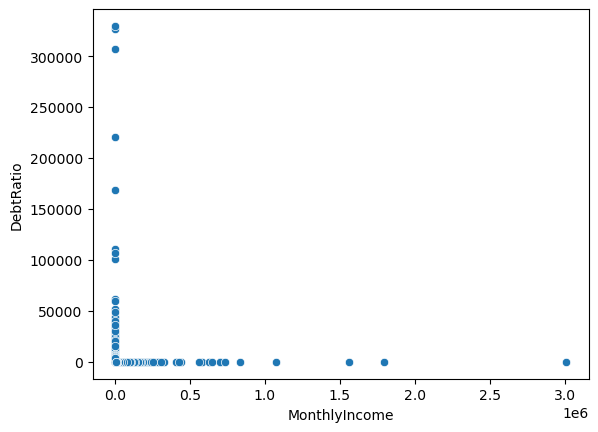

In [11]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df)

##### Let's build the chart again with a limitation on the value of monthly income up to 5

<AxesSubplot: xlabel='MonthlyIncome', ylabel='DebtRatio'>

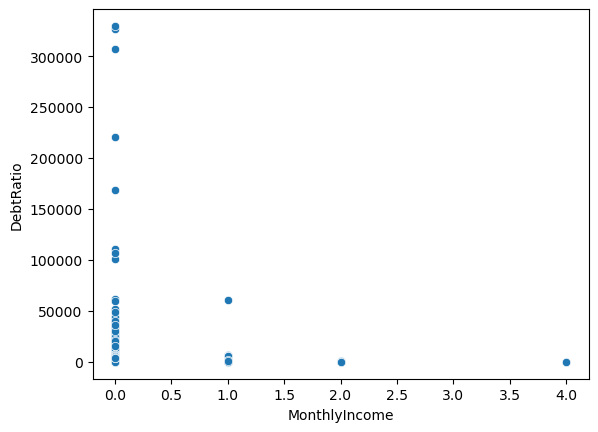

In [53]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df.loc[df.MonthlyIncome<5])

##### Calculate how DebtRatio is distributed depending on income

In [13]:
pd.qcut(df.loc[df['MonthlyIncome']==-1, 'DebtRatio'],90, duplicates="drop").value_counts()

(-0.001, 1.0]           1827
(2.0, 5.0]               450
(7.0, 11.0]              417
(37.0, 44.0]             358
(22.0, 27.0]             353
(51.0, 60.0]             348
(31.0, 37.0]             347
(1761.0, 1816.0]         341
(297.0, 344.0]           338
(1006.0, 1056.0]         338
(81.0, 96.0]             337
(1353.0, 1398.0]         337
(598.333, 653.0]         336
(96.0, 113.0]            335
(1865.667, 1926.0]       335
(2038.667, 2105.0]       335
(168.0, 207.0]           335
(1446.0, 1493.0]         334
(2415.0, 2486.0]         334
(2817.333, 2910.0]       334
(1708.0, 1761.0]         334
(3010.0, 3114.0]         333
(1547.0, 1599.0]         332
(432.0, 473.0]           332
(653.0, 701.0]           332
(804.0, 858.0]           332
(1159.0, 1207.0]         332
(388.0, 432.0]           332
(2163.0, 2225.0]         332
(4166.667, 4416.0]       332
(1599.0, 1651.0]         331
(2352.0, 2415.0]         331
(2562.333, 2642.0]       331
(3463.333, 3604.0]       331
(5094.333, 558

Conclusion: as can be seen from the presented graph and possible values of DebtRatio - most likely with N / A Values, zero income is meant, because. DebtRatio is significantly greater than zero in most cases, but this cannot be, a person cannot be given loans more than he can repay. So the most justified approach is: for those cases where DebtRatio <1, fill N/A with the median value for the column, in other cases, assign the value 0.

In [14]:
df.loc[(df.MonthlyIncome==-1)&(df.DebtRatio<1), 'MonthlyIncome']=df.MonthlyIncome.median()
df.loc[df['MonthlyIncome']==-1, 'MonthlyIncome']=0

##### 04. Check the values in the 'NumberOfTimes90DaysLate' column

In [15]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.NumberOfTimes90DaysLate.value_counts()).sort_index()

,NumberOfTimes90DaysLate
0,141661
1,5243
2,1555
3,667
4,291
5,131
6,80
7,38
8,21
9,19


##### As for 'NumberOfTime30-59DaysPastDueNotWorse', here we also replace the values 96 and 98 with 6 and 8

In [16]:
df.loc[df['NumberOfTimes90DaysLate']==96, 'NumberOfTimes90DaysLate']=6
df.loc[df['NumberOfTimes90DaysLate']==98, 'NumberOfTimes90DaysLate']=8

##### 05 Same for NumberOfTime60-89DaysPastDueNotWorse. Replace 96 and 98 with 6 and 8

In [17]:
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==96, 'NumberOfTime60-89DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==98, 'NumberOfTime60-89DaysPastDueNotWorse']=8

##### 06. Check the NumberOfDependents values

In [18]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfDependents'].value_counts())

,NumberOfDependents
0.0,86902
1.0,26316
2.0,19521
3.0,9483
4.0,2862
5.0,746
6.0,158
7.0,51
8.0,24
10.0,5


In [19]:
pd.set_option('display.max_rows', 10)

Conclusion: Fill in the gaps with the median value

In [20]:
df.NumberOfDependents.fillna(df.NumberOfDependents.median(), inplace=True)

##### 07. Look for duplicates in the set

In [21]:
sum(df.duplicated())

768

##### Remove duplicates

In [22]:
df.drop(df.loc[df.duplicated()].index, axis=0, inplace=True)

##### 08. Estimate the number of those who returned and did not return the loan

In [23]:
df.SeriousDlqin2yrs.value_counts()

0    139227
1     10004
Name: SeriousDlqin2yrs, dtype: int64

##### Conclusion: In this case, we are dealing with an unbalanced set. As a metric when training models, it is most optimal to use Precision, Recall, F-measure, ROC-AUC

##### 09. Build a correlation matrix

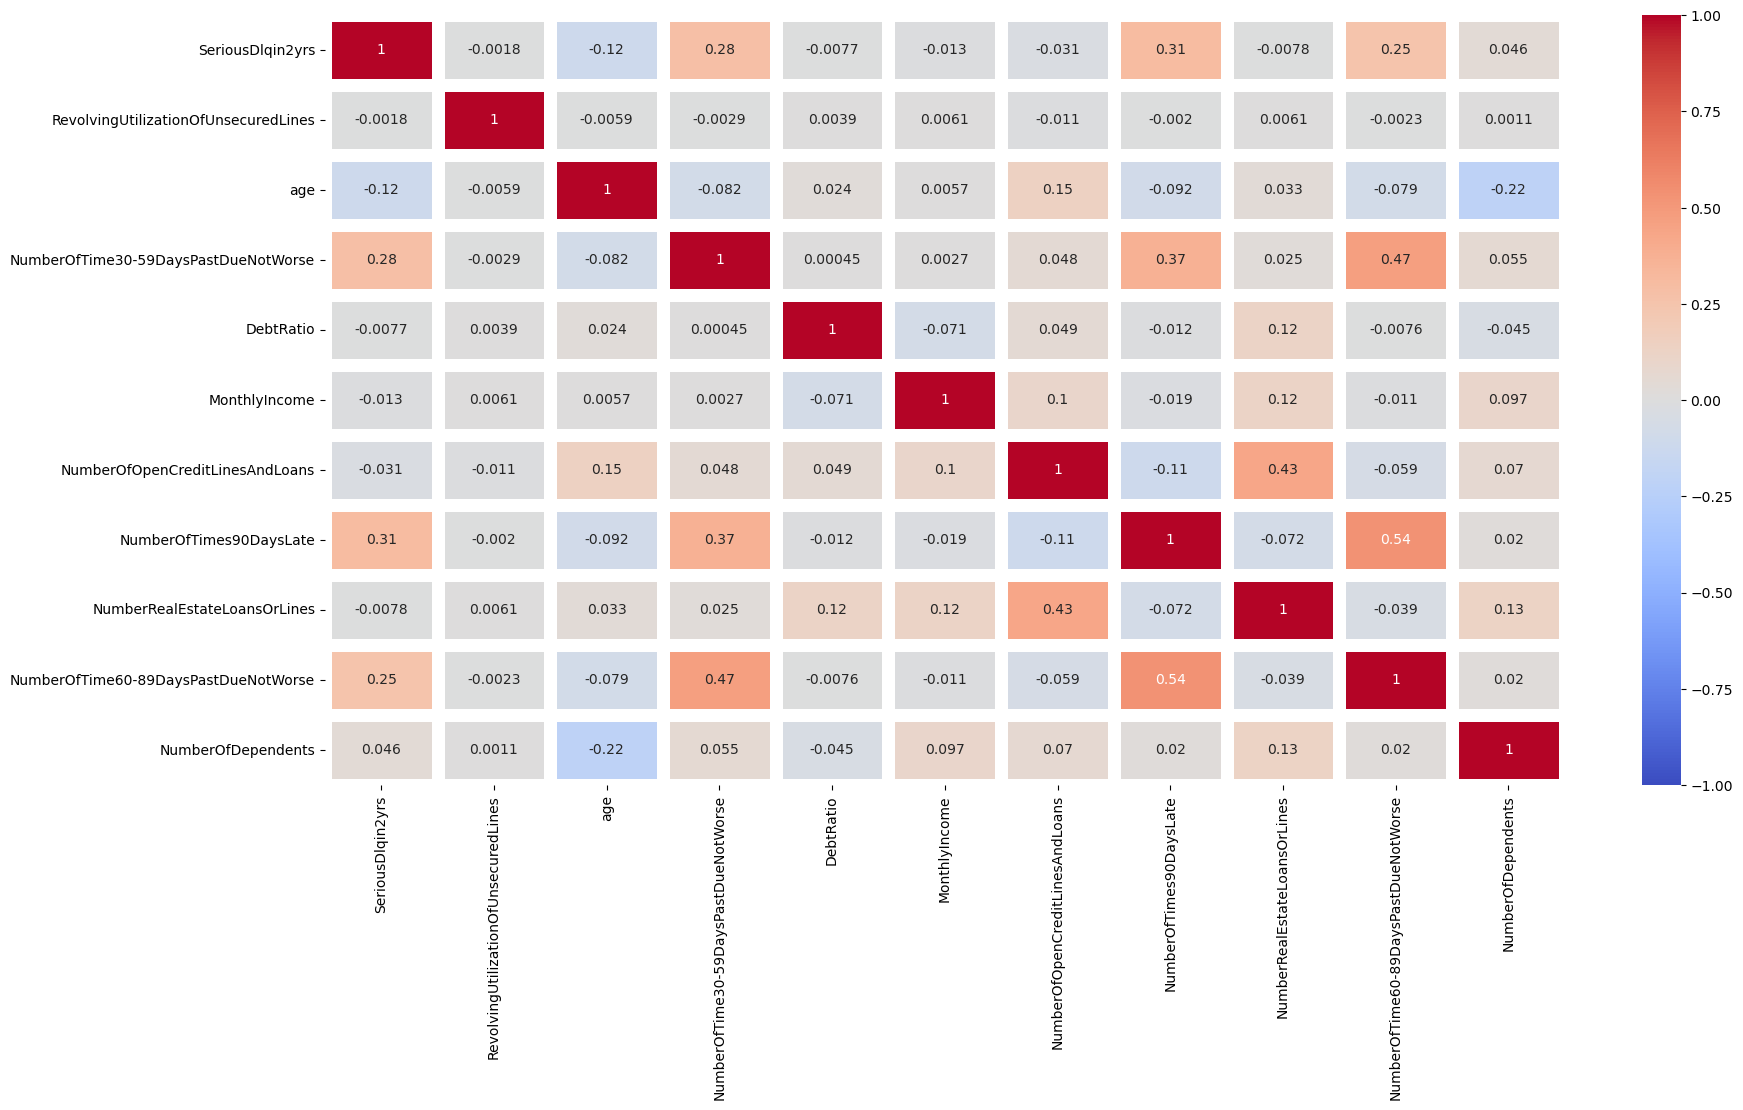

In [24]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),
            annot=True, 
            vmin=-1, vmax=1, 
            center= 0, 
            cmap= 'coolwarm', 
            linewidths=9, 
            linecolor='white', 
            cbar_kws= {'orientation': 'vertical'});

Correlation can be seen among two groups of features:

* 1. __NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse__
* 2. __NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines__

What can say that:
1) A client who has overdue payment by 30-59 days will overdue it by 60-89 and 90 days.

2) A loan for an apartment is already included in the attribute "Number of open loans"

##### 10. Visualization of the connection between income and non-returns.

<AxesSubplot: xlabel='MonthlyIncome', ylabel='count'>

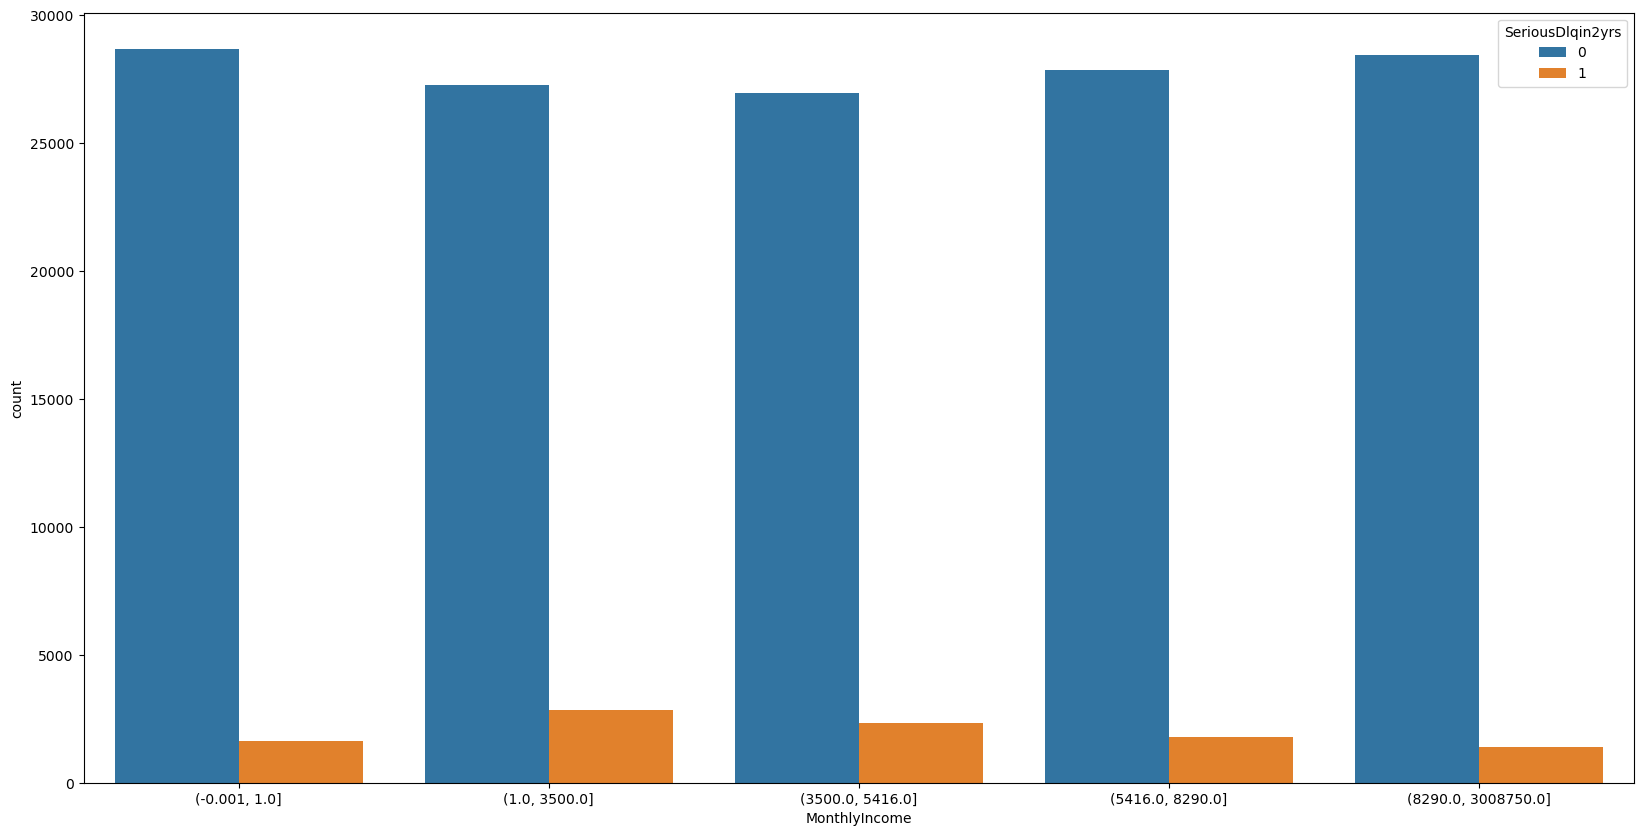

In [25]:
income_binned = income_binned = pd.qcut (df.MonthlyIncome, 5, duplicates='drop')

plt.figure(figsize=(20,10))
sns.countplot (x=income_binned, hue=df.SeriousDlqin2yrs)

Conclusion: This graph shows an interesting connection. Those people who currently have virtually zero income (probably as a result of losing their jobs) have fewer defaults than those who are chronically underpaid. Further, the number of non-returns decreases as income increases.

# Part 2 - Training the model:

In [26]:
X=df.drop('SeriousDlqin2yrs',axis=1)
y=df['SeriousDlqin2yrs']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### Logistic regression

In [28]:
lr=LogisticRegression()
sds=StandardScaler()

In [29]:
parameters = {"C":np.logspace(-3,3,7)}
pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(lr,parameters,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.936 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.936 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.936 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.935 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.936 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.936 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.936 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                              verbose=3))])

In [30]:
pipeline.named_steps['gs'].best_params_

{'C': 1.0}

In [31]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])


0.8076377156003182

##### Random forest

In [32]:
rfc=RandomForestClassifier()
sds=StandardScaler()

In [35]:
param_grid = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [1,2,4],
    'criterion': ['gini', 'entropy', 'log_loss']
}

pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(rfc,param_grid,cv=5,verbose=3)
                     )])


pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   2.3s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   2.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   2.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   2.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   2.2s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   2.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   2.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   2.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   2.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   2.2s
[CV 1/5] 

[CV 2/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.1s
[CV 3/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.2s
[CV 4/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.0s
[CV 5/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.1s


Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy',
                                                        'log_loss'],
                                          'max_depth': [1, 2, 4],
                                          'max_features': ['sqrt', 'log2']},
                              verbose=3))])

In [36]:
pipeline.named_steps['gs'].best_params_

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt'}

In [37]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.855844343206402

#### Вывод: Лучший результат демонстрирует RandomForestClassifier() с максимальной глубиной 10 и max_features - auto - 85.51

# Part 3 - Future extraction

#### 01. Estimate the number of loans by the number of dependents

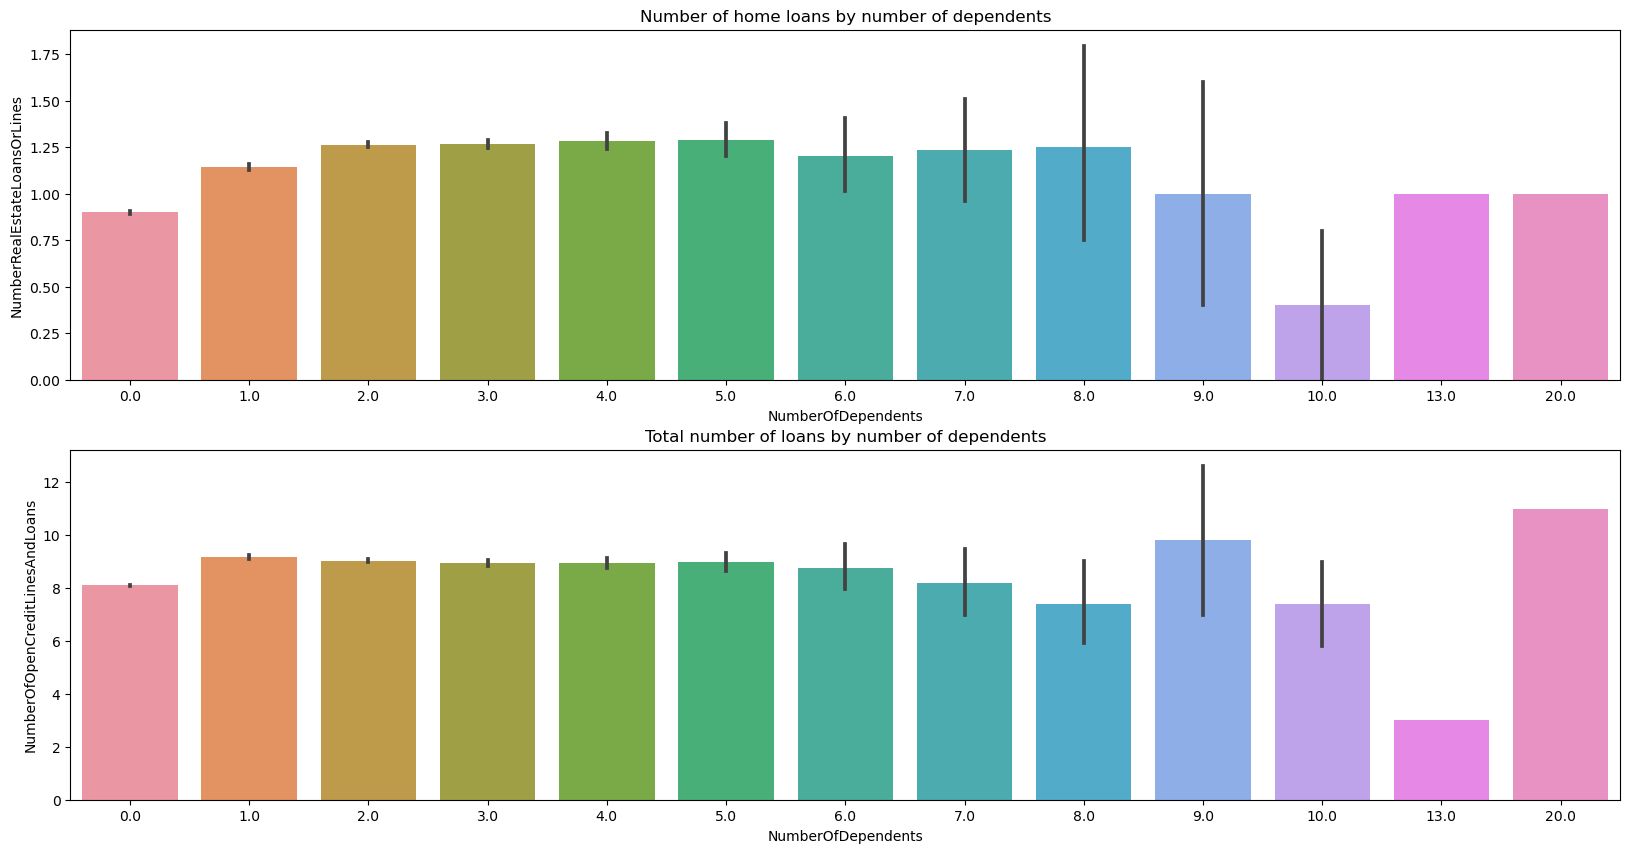

In [38]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberRealEstateLoansOrLines');
plt.title ('Number of home loans by number of dependents');

plt.subplot (2,1,2)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberOfOpenCreditLinesAndLoans');
plt.title ('Total number of loans by number of dependents');

#### Conclusion: people without or with 9 or more dependents have the least housing loans. And people with 9 and 20 dependents have the most other loans.

#### 02. Estimate the number of arrears depending on the number of dependents after grouping

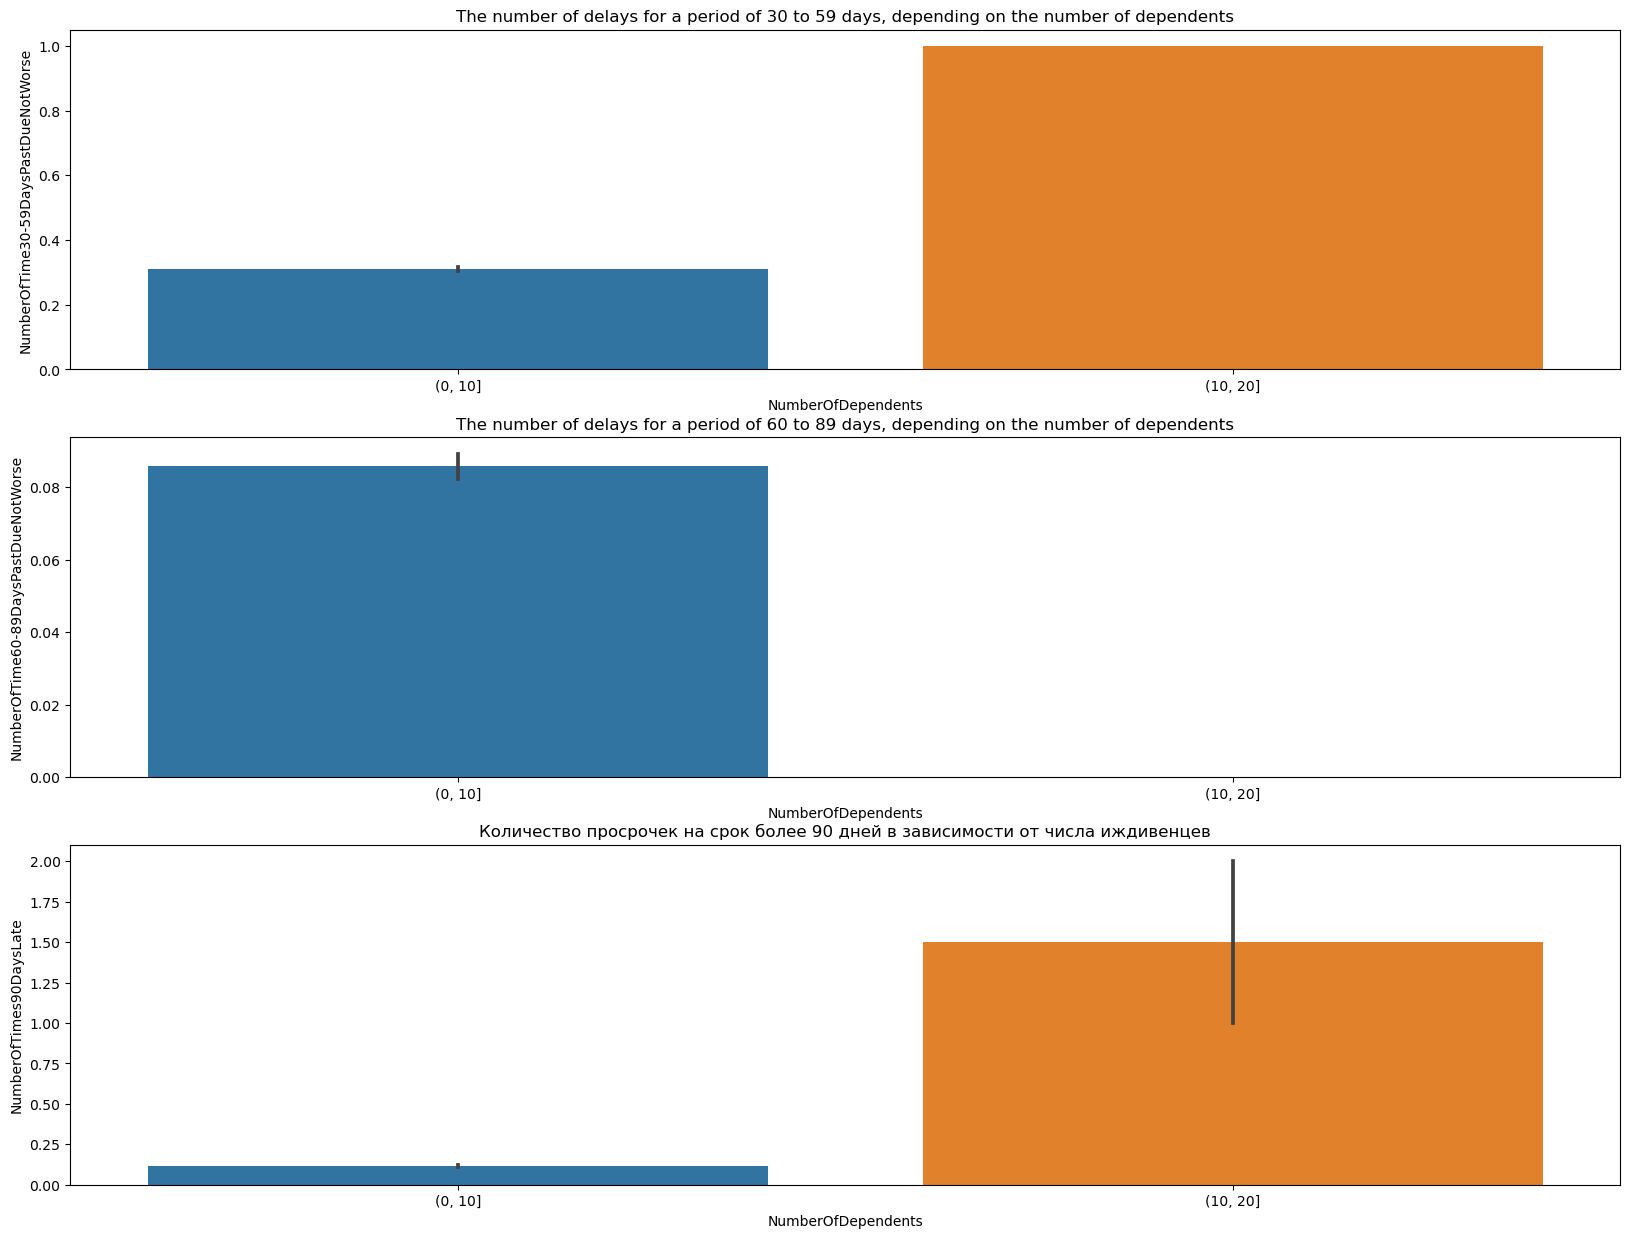

In [39]:
plt.figure(figsize=(20,15))

binned_val = pd.cut(df.NumberOfDependents, 
                   bins = [0,10,20])

plt.subplot (3,1,1)
sns.barplot(data=df, x=binned_val, y='NumberOfTime30-59DaysPastDueNotWorse')
plt.title ('The number of delays for a period of 30 to 59 days, depending on the number of dependents');


plt.subplot (3,1,2)
sns.barplot(data=df, x=binned_val, y='NumberOfTime60-89DaysPastDueNotWorse')
plt.title ('The number of delays for a period of 60 to 89 days, depending on the number of dependents');

plt.subplot (3,1,3)
sns.barplot(data=df, x=binned_val, y='NumberOfTimes90DaysLate')
plt.title ('Количество просрочек на срок более 90 дней в зависимости от числа иждивенцев');

##### Outcome: Based on the presented graphs, I would divide all cases into 2 groups: 0-10 - Group 1, 11-20 - Group 2##### Итог: Исходя из представленных графиков я бы разбил все случаи на 2 группы: 0-10 - Группа 1, 11-20 - Группа 2

In [40]:
df.loc[(df.NumberOfDependents>=0) & (df.NumberOfDependents<=10), 'BinNumberOfDependents']=1
df.loc[(df.NumberOfDependents>=11), 'BinNumberOfDependents']=2

#### 03. Estimate the total number of open credit lines for general and real estate

<AxesSubplot: xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

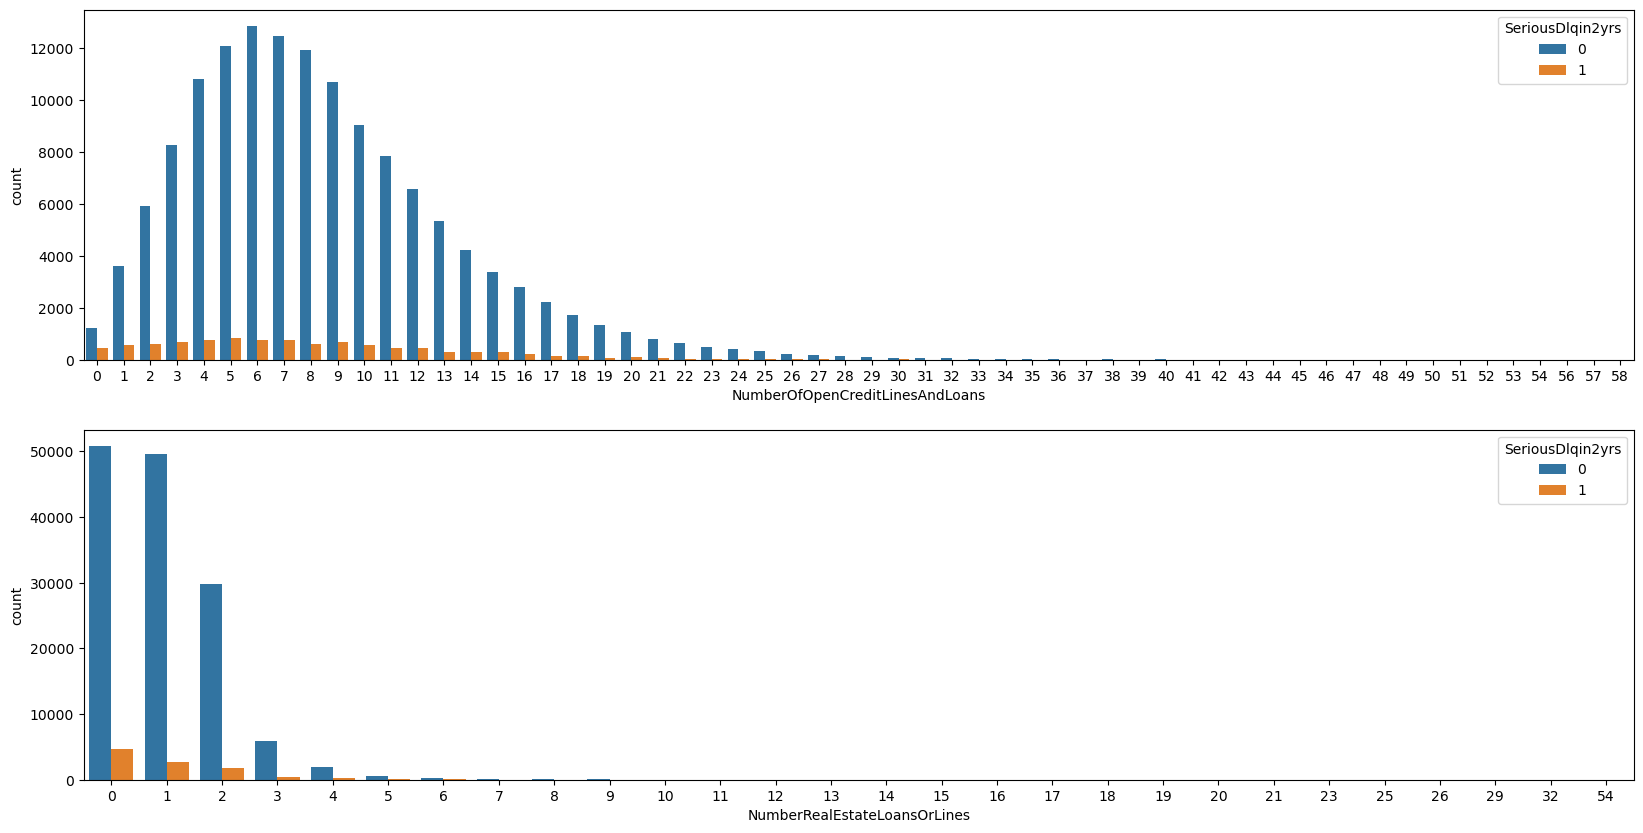

In [41]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['NumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['NumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

#### Bottom line: Based on the graphs presented, I would break the total loans into intervals: 0-12 - Group 1, 13-20 - Group 2, 21 or more - Group 3.

#### Housing loans for: 0-2 - Group 1, 3 and more - Group 2 real estate

In [42]:
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=0) & (df.NumberOfOpenCreditLinesAndLoans<=12), 'BinNumberOfOpenCreditLinesAndLoans']=1
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=13) & (df.NumberOfOpenCreditLinesAndLoans<=20), 'BinNumberOfOpenCreditLinesAndLoans']=2
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=21), 'BinNumberOfOpenCreditLinesAndLoans']=3

In [43]:
df.loc[(df.NumberRealEstateLoansOrLines>=0) & (df.NumberRealEstateLoansOrLines<=2), 'BinNumberRealEstateLoansOrLines']=1
df.loc[(df.NumberRealEstateLoansOrLines>=3), 'BinNumberRealEstateLoansOrLines']=2

<AxesSubplot: xlabel='BinNumberRealEstateLoansOrLines', ylabel='count'>

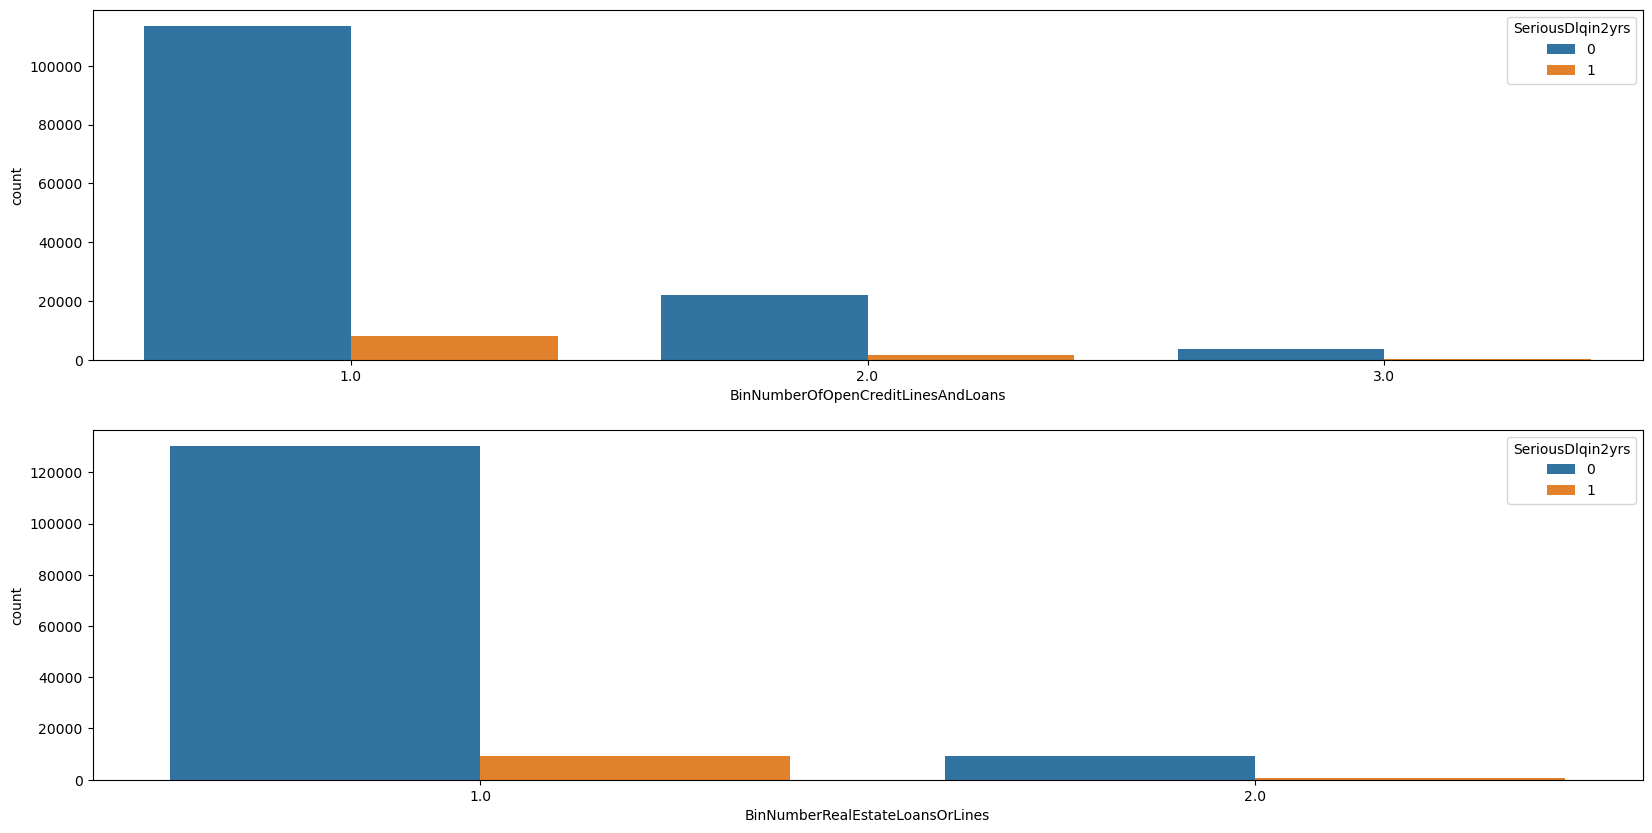

In [44]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['BinNumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['BinNumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

# Part 4 - Model training after future extraction

In [45]:
X=df.drop(['SeriousDlqin2yrs','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'],axis=1)
y=df['SeriousDlqin2yrs']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### Logistic regression

In [47]:
parameters = {"C":np.logspace(-3,3,7)}
pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(lr,parameters,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.936 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.935 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.935 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.935 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.935 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.937 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.936 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.936 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                              verbose=3))])

In [48]:
pipeline.named_steps['gs'].best_params_

{'C': 1.0}

In [49]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])


0.81063787224492

##### 05.1. Случайный лес

In [50]:
param_grid = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [1,2,4],
    'criterion': ['gini', 'entropy', 'log_loss']
}

pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(rfc,param_grid,cv=5,verbose=3)
                     )])


pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   1.7s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   1.8s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   1.8s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   1.8s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.932 total time=   1.9s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   1.8s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   1.9s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   1.8s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   1.8s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2;, score=0.932 total time=   1.8s
[CV 1/5] 

[CV 2/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.1s
[CV 3/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.1s
[CV 4/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.1s
[CV 5/5] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.935 total time=   5.3s


Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy',
                                                        'log_loss'],
                                          'max_depth': [1, 2, 4],
                                          'max_features': ['sqrt', 'log2']},
                              verbose=3))])

In [51]:
pipeline.named_steps['gs'].best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt'}

In [52]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.8554786506393821

___After the introduction of new functions, the logistic regression improved to 81.06. As for the decision tree, the result, on the contrary, decreased slightly to 85.554___.

# General conclusions

1. As a result of the work carried out, data analysis was carried out, the data set was cleaned, gaps were processed.
2. A visual evaluation of the data was carried out.
3. It has been established that the total number of loans, as well as the number of non-real estate loans, affects the probability of loan default. Moreover, their number, in turn, is affected by the number of dependents.
4. After training the logistic regression and random forest models and selecting their parameters, it was revealed that the best result is shown by RF, 0.856 versus 0.807, with the parameters {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt '}
5. After working with the data and performing the future extraction operation, the results for both LR increased to 0.81, while those for RF deteriorated slightly.